In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
st_market_info = pd.read_html("https://coinmarketcap.com/currencies/stellar/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
st_market_info = st_market_info.assign(Date=pd.to_datetime(st_market_info['Date']))
st_market_info.columns =[st_market_info.columns[0]]+['st_'+i for i in st_market_info.columns[1:]]

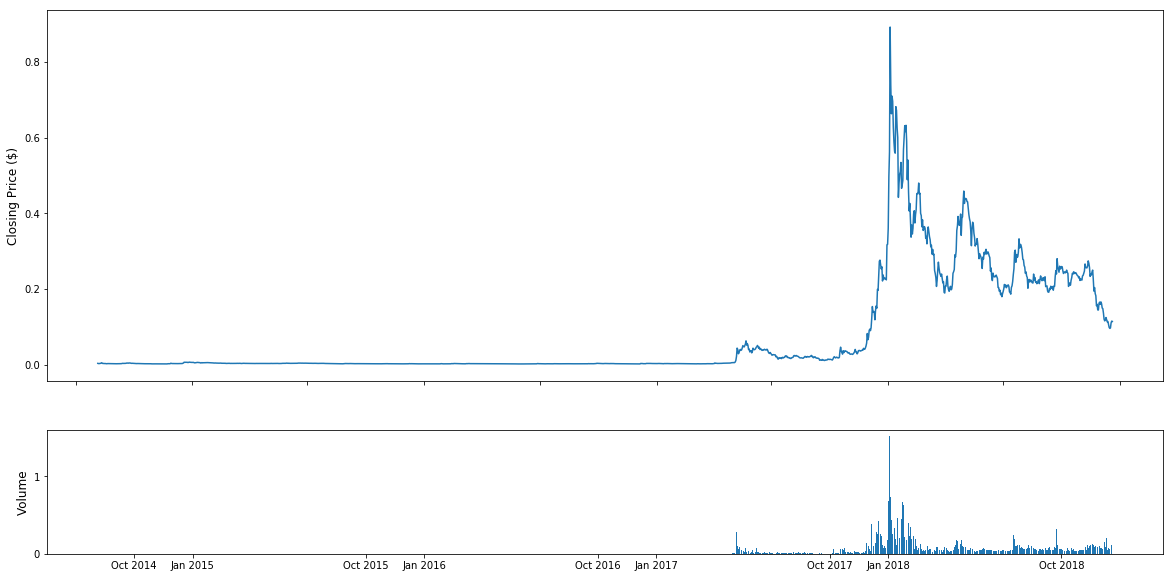

In [2]:
import warnings; warnings.filterwarnings('ignore') 
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,10]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,10]])
ax1.plot(st_market_info['Date'].astype(datetime.datetime),st_market_info['st_Open*'])
ax2.bar(st_market_info['Date'].astype(datetime.datetime).values, st_market_info['st_Volume'].values)
plt.show()

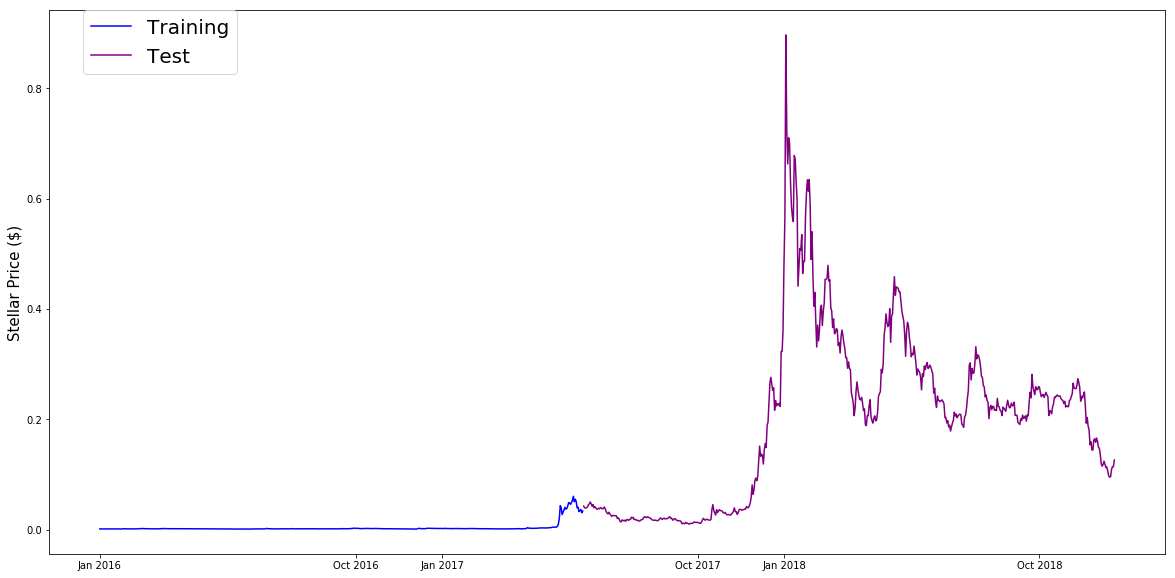

In [3]:
market_info = st_market_info
market_info = market_info[market_info['Date']>='2016-01-01']
split_date = '2017-06-01'
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,10]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,10]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['st_Close**'], 
         color='BLUE', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['st_Close**'], 
         color='PURPLE', label='Test')
ax1.set_ylabel('Stellar Price ($)',fontsize=15)
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 20})

for coins in ['st_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close**'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open*']), coins+'day_diff': lambda x: (x[coins+'Close**']-x[coins+'Open*'])/x[coins+'Open*']}
    market_info = market_info.assign(**kwargs)
model_data = market_info[['Date']+[coin+metric for coin in ['st_'] 
                                   for metric in ['Close**','Volume']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')



In [4]:
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)
window_len = 10
norm_cols = [coin+metric for coin in ['st_'] for metric in ['Close**','Volume']]
LSTM_training_inputs = []
def norm(x):
    for col in x:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    norm(norm_cols)
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['st_Close**'][window_len:].values/training_set['st_Close**'][:-window_len].values)-1
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    norm(norm_cols)
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['st_Close**'][window_len:].values/test_set['st_Close**'][:-window_len].values)-1
LSTM_training_inputs[0]
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)
LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [5]:
#TO TRAIN THE MODEL
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model
np.random.seed(202)
# initialise model architecture
st_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['st_Close**'][window_len:].values/training_set['st_Close**'][:-window_len].values)-1
# train model on data
st_history = st_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=30, batch_size=1, verbose=2, shuffle=True)



Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/30
 - 5s - loss: 0.2272
Epoch 2/30
 - 3s - loss: 0.1645
Epoch 3/30
 - 3s - loss: 0.1522
Epoch 4/30
 - 4s - loss: 0.1369
Epoch 5/30
 - 4s - loss: 0.1421
Epoch 6/30
 - 4s - loss: 0.1164
Epoch 7/30
 - 4s - loss: 0.1103
Epoch 8/30
 - 4s - loss: 0.1156
Epoch 9/30
 - 4s - loss: 0.1043
Epoch 10/30
 - 4s - loss: 0.1016
Epoch 11/30
 - 4s - loss: 0.1040
Epoch 12/30
 - 4s - loss: 0.0940
Epoch 13/30
 - 4s - loss: 0.0958
Epoch 14/30
 - 3s - loss: 0.0912
Epoch 15/30
 - 4s - loss: 0.0965
Epoch 16/30
 - 4s - loss: 0.0878
Epoch 17/30
 - 4s - loss: 0.1025
Epoch 18/30
 - 4s - loss: 0.0918
Epoch 19/30
 - 4s - loss: 0.0954
Epoch 20/30
 - 4s - loss: 0.0909
Epoch 21/30
 - 4s - loss: 0.1011
Epoch 22/30
 - 4s - loss: 0.0915
Epoch 23/30
 - 4s - loss: 0.1001
Epoch 24/30
 - 4s - loss: 0.0934
Epoch 25/30
 - 4s - loss: 0.0916
Epoch 26/30
 - 5s - loss: 0.0962
Epoch

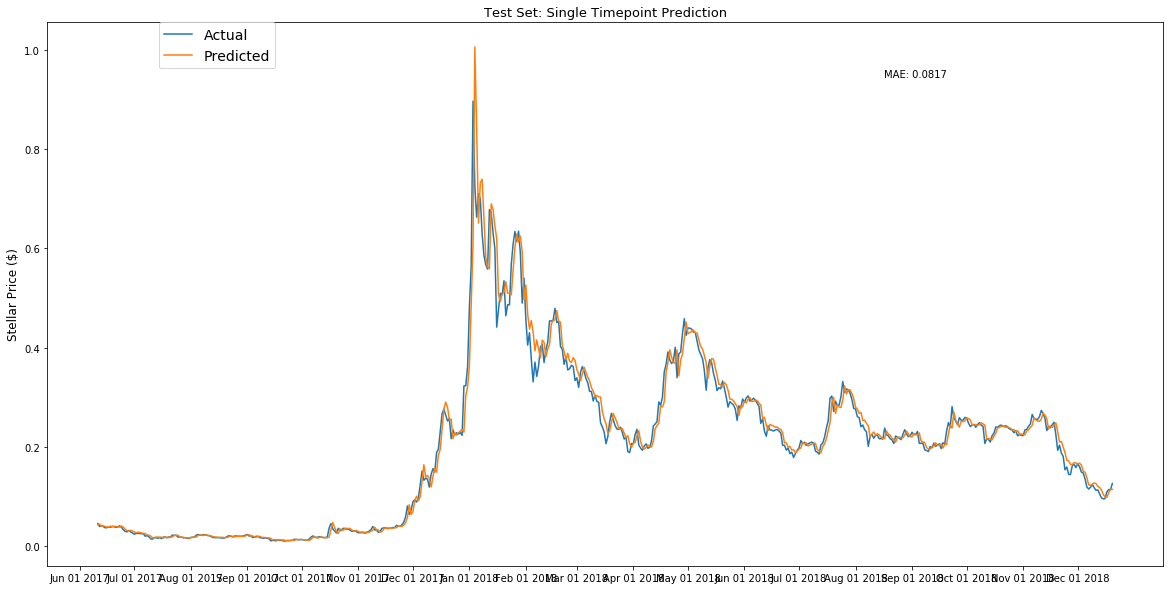

In [6]:
import datetime as datetime
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)]+ [datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)] + [datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])

ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['st_Close**'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(st_model.predict(LSTM_test_inputs))+1) * test_set['st_Close**'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(st_model.predict(LSTM_test_inputs))+1)-\
            (test_set['st_Close**'].values[window_len:])/(test_set['st_Close**'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Stellar Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()


In [27]:
import datetime as datetime
st_pred2=(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
           test_set['st_Close**'][window_len:])
         
st_pred1=(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),(((np.transpose(st_model.predict(LSTM_test_inputs))+1) * test_set['st_Close**'].values[:-window_len])[0]))

df1=pd.DataFrame({'Date':st_pred1[0], 'Predicted Closing Price': st_pred1[1]})
df2=pd.DataFrame({'Date':st_pred2[0], 'Actual Closing Price': st_pred2[1]})
df3=pd.merge(df2,df1, on=['Date'], how='inner')
df3.index = pd.to_datetime(df3['Date'])
df3 = df3[['Actual Closing Price', 'Predicted Closing Price' ]]
change=df3['Predicted Closing Price']-df3['Actual Closing Price']
changeper=abs((change/df3['Predicted Closing Price'])*100)
df3['Change']=change
df3['Change percentage']=changeper

In [28]:
from datetime import datetime
lis=[datetime.utcnow().strftime("%Y-%m-%d %I:%M:%S"), np.nan,np.nan]
df5=pd.DataFrame([lis], columns=['Date','Actual Closing Price', 'Predicted Closing Price'])
df5=df5.set_index('Date')
forecast1=pd.concat([df3,df5])
forecast1['Predicted Closing Price']=forecast1['Predicted Closing Price'].shift(1)
forecast1['Change']=forecast1['Change'].shift(1)
forecast1['Change percentage']=forecast1['Change percentage'].shift(1)

In [31]:
df=forecast1[1:]

In [ ]:
df['Date']=df.index

In [ ]:
import plotly
plotly.tools.set_credentials_file(username='samridhivaid', api_key='Vx7UzWPiInLQmDiwv3Q9')

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd


trace_high = go.Scatter(
    x=df.Date,
    y=df['Actual Closing Price'],
    name = "Actual Closing Price",
    line = dict(color = '#17BECF'),
    opacity = 0.8)

trace_low = go.Scatter(
    x=df.Date,
    y=df['Predicted Closing Price'],
    name = "Predicted Closing Price",
    line = dict(color = '#7F7F7F'),
    opacity = 0.8)

data = [trace_high,trace_low]

layout = dict(
    title='Lumen',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Stellar Prediction")

In [32]:
df_mae = df.copy()
df_mae["Predicted Closing Price"] = df_mae["Predicted Closing Price"].shift(1)
df_mae.dropna(axis = 0, inplace = True)
from sklearn.metrics import mean_absolute_error
#print("MAE : ",mean_absolute_error(df_mae["Predicted Closing Price"], df_mae["Actual Closing Price"]))
df_dummy = df.copy()
df_dummy.rename(index=str, columns={"Predicted Closing Price": "Tomorrow's Forecast"}, inplace=True)
df_D=df_dummy.ix[-1:,["Tomorrow's Forecast","Change", "Change percentage"]]

In [33]:
df_D

,Tomorrow's Forecast,Change,Change percentage
Date,,,
2018-12-21 11:32:44,0.114652,-0.011898,10.377205


In [34]:
import json as json
# Convert to json
input_json = df_D.to_json()
f = open('stellar_output_file', 'w')
f.write(input_json)
f.close()